## Injecting back lost modes

In [1]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import pymaster as nmt

In [3]:
NSIDE = 512
lmax = 2*NSIDE

In [4]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [5]:
l_arr = np.arange(0,lmax+1)

In [6]:
planck_sim = 'cmbnoise_28scan/'
s4_sim_dc0 = 'cmb_s4scan_dc0/'
s4_sim_destriping = 'cmb_s4scan_destriping/'

In [7]:
cmb_noiseless = 'cmb_28scan/'

In [8]:
mode_list = ['T','E','B']

In [9]:
IQU_list = ['I','Q','U']

In [10]:
aposcale = .1

Input map contains CMB and Planck noise

In [11]:
cmbnoise_input = hp.read_map(filename='cmbnoise_030_GC_nside.FITS',field = None)

In [12]:
cmb_input = hp.read_map(filename='cmb_030_GC_nside.FITS',field = None)

In [13]:
noise_GC512 = hp.read_map('noise_030_GC_nside.FITS',field=None)

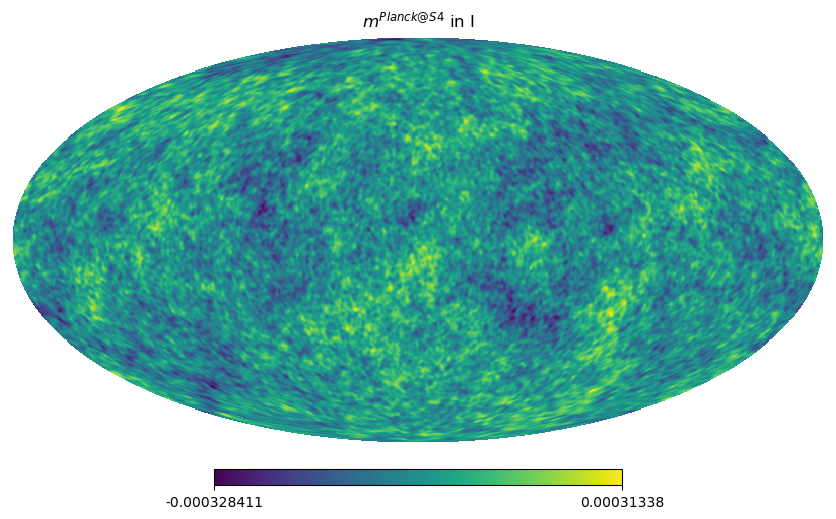

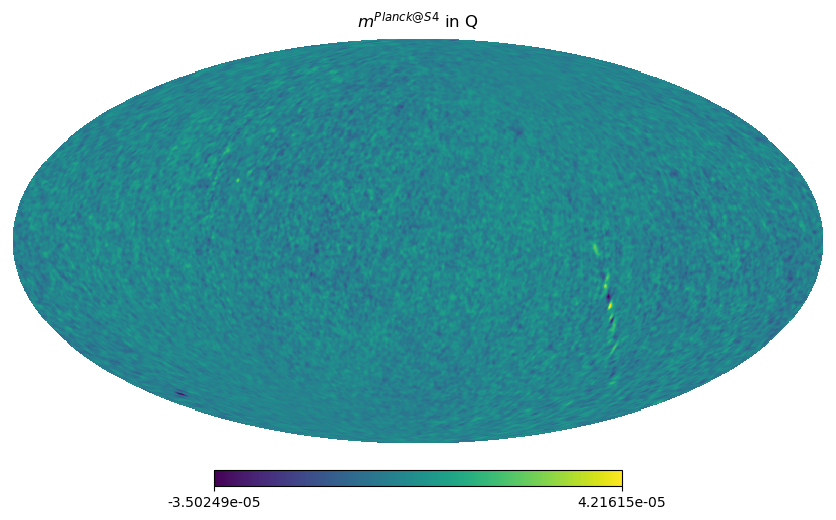

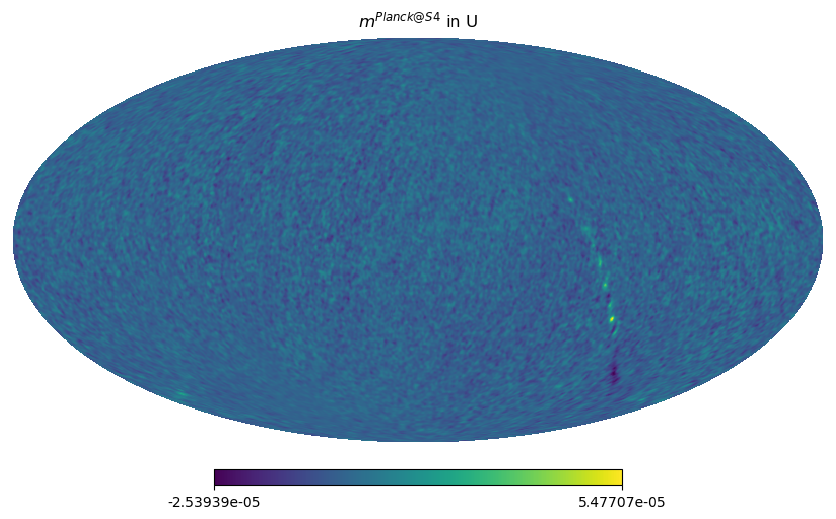

In [14]:
for i in range(3):
    hp.mollview(cmbnoise_input[i],title = r'$m^{Planck @ S4}$ in '+IQU_list[i])
    plt.savefig('figures/map_cmbnoise_'+IQU_list[0]+'.svg')

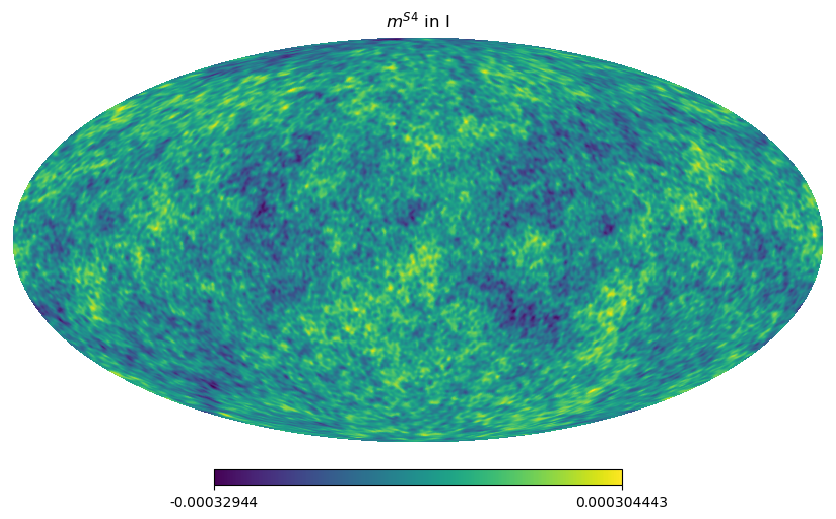

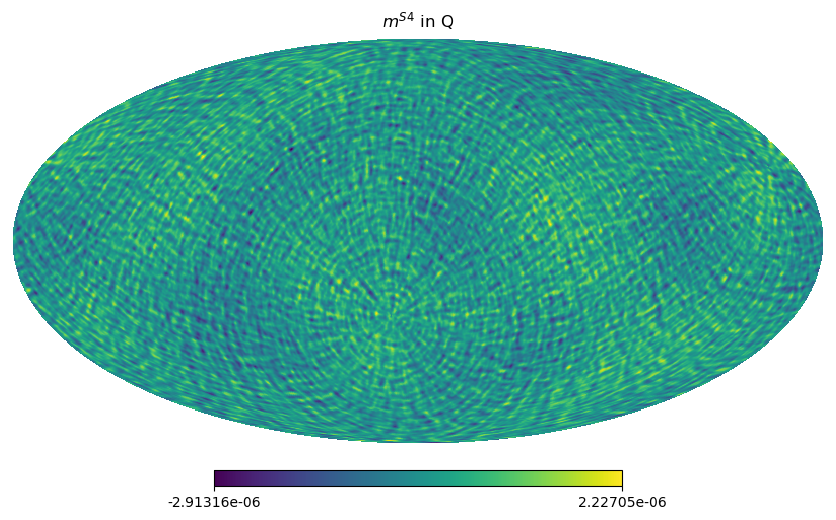

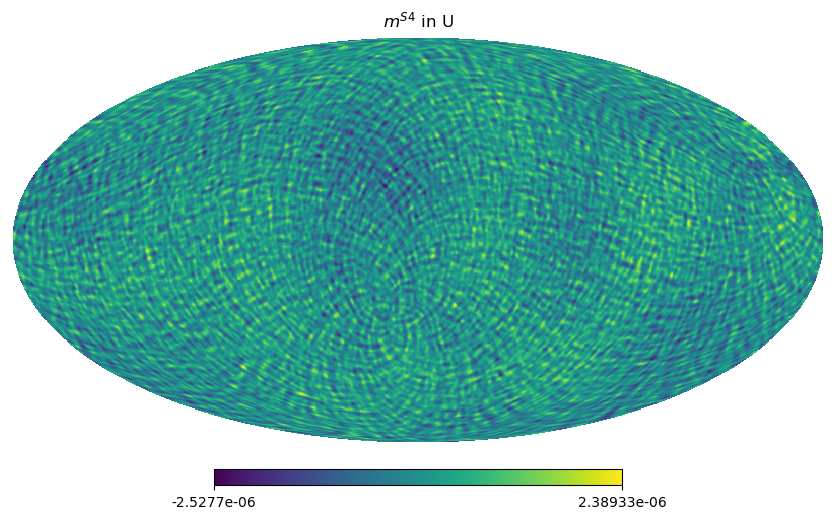

In [15]:
for i in range(3):
    hp.mollview(cmb_input[i],title = r'$m^{S4}$ in '+IQU_list[i])
    plt.savefig('figures/map_cmb_'+IQU_list[0]+'.svg')

In [16]:
Dl_cmb_in = D_ell(maps=cmb_input,lmax= lmax)
Dl_cmbnoise_in = D_ell(maps=cmbnoise_input,lmax= lmax)


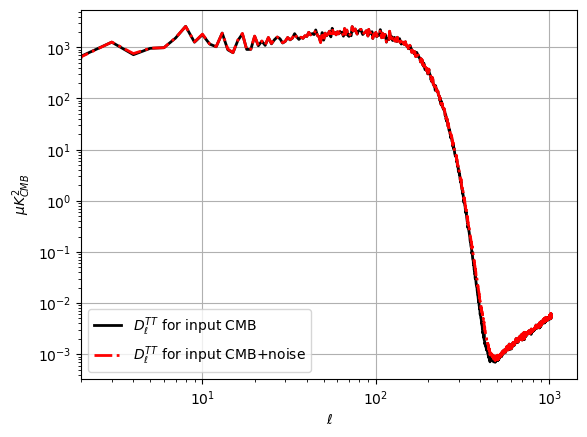

In [17]:
plt.plot(l_arr,Dl_cmb_in[0]*1e12,'k',  label = r'$D_\ell^{TT}$ for input CMB',linewidth = 2)
#plt.plot(l_arr,Dl_cmb_in[1]*1e12,'r',  label = r'$D_\ell^{EE}$ for input CMB',linewidth = 2)
#plt.plot(l_arr,Dl_cmb_in[2]*1e12,'b',  label = r'$D_\ell^{BB}$ for input CMB',linewidth = 2)
plt.plot(l_arr,Dl_cmbnoise_in[0]*1e12,'r-.',  label = r'$D_\ell^{TT}$ for input CMB+noise',linewidth = 2)
#plt.plot(l_arr,Dl_cmbnoise_in[1]*1e12,'r-.',  label = r'$D_\ell^{EE}$ for input CMB+noise',linewidth = 2)
#plt.plot(l_arr,Dl_cmbnoise_in[2]*1e12,'b-.',  label = r'$D_\ell^{BB}$ for input CMB+noise',linewidth = 2)
plt.xlabel('$\ell$')
plt.ylabel('$\mu K_{CMB}^2$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.xlim(left = 2)
plt.grid()
##plt.savefig(output_noise+'/cls_comparison'+2*mode_list[0]+'.svg')
plt.show()

In [18]:
diff_tot = cmbnoise_input-cmb_input-noise_GC512


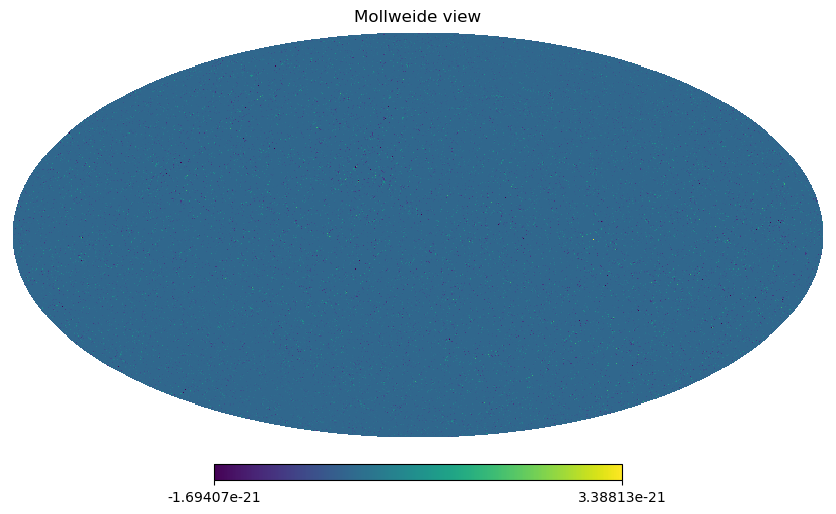

In [19]:
hp.mollview(diff_tot[2])

Both pipelines are performed on a noisy Planck map $bs+n$

In [20]:
cmbnoise_dc0= hp.read_map(planck_sim+"/FilterBin_filtered_map.fits", dtype = float,field = None)
cmbnoise_rcond_dc0= hp.read_map(planck_sim+"/FilterBin_rcond.fits", dtype = float,field = None)
cmbnoise_destriping= hp.read_map(planck_sim+"/MapMaker_map.fits", dtype = float,field = None)
cmbnoise_rcond= hp.read_map(planck_sim+"/MapMaker_rcond.fits", dtype = float,field = None)

Both pipelines are performed on a sky-signal map with detector noise $bs\rightarrow $Noisy TOD

In [21]:
s4sim_dc0= hp.read_map(s4_sim_dc0+"/FilterBin_filtered_map.fits", dtype = float,field = None)
s4sim_rcond_dc0= hp.read_map(s4_sim_dc0+"/FilterBin_rcond.fits", dtype = float,field = None)

In [22]:
s4sim_destriping= hp.read_map(s4_sim_destriping+"/MapMaker_map.fits", dtype = float,field = None)
s4sim_rcond= hp.read_map(s4_sim_destriping+"/MapMaker_rcond.fits", dtype = float,field = None)


Both pipelines are performed on a sky-signal map without detector noise

In [87]:
cmb_destriping = hp.read_map('cmb_28scan/MapMaker_map.fits',field=None)
cmb_dc0 = hp.read_map('cmb_28scan/FilterBin_filtered_map.fits',field=None)

In [88]:
def rcond_mask_apodized(map_rcond,thrsh = 1e-3,apo = aposcale):
    mask_map = np.zeros(map_rcond.shape)
    mask_map[map_rcond>thrsh]=1
    mask_map_sm = nmt.mask_apodization(mask_map, apo, apotype="Smooth")
    return(mask_map_sm)

In [89]:
def masked_map(map_in,mask):
    temp = np.zeros(map_in.shape)
    temp[:,:] = map_in[:,:]
    temp[:,mask==0] = hp.UNSEEN
    return(temp)

In [90]:
def diff_mask(m1,m2,mask):
    temp = m1-m2
    return (masked_map(temp, mask))

In [91]:
mask_sm = rcond_mask_apodized(cmbnoise_rcond)

In [92]:
np.save(file='Apodized_mask', arr=mask_sm)

In [93]:
masked_cmbnoise_in = masked_map(map_in=cmbnoise_input,mask=mask_sm)
masked_cmbnoisedc0 = masked_map(map_in=cmbnoise_dc0,mask=mask_sm)
masked_cmbnoisedestriping = masked_map(map_in=cmbnoise_destriping,mask=mask_sm)
masked_s4_dc0 = masked_map(map_in=s4sim_dc0,mask=mask_sm)
masked_s4_destriping = masked_map(map_in=s4sim_destriping,mask=mask_sm)

In [94]:
masked_cmb_in = masked_map(map_in=cmb_input,mask=mask_sm)
mask_cmb_des = masked_map(cmb_destriping,mask_sm)
mask_cmb_dc0 = masked_map(cmb_dc0,mask_sm)


In [95]:
diff_cmb_dc0 = diff_mask(cmb_input, mask_cmb_dc0,mask_sm)
diff_cmb_des = diff_mask(cmb_input, mask_cmb_des,mask_sm)
diff_cmbnoise_dc0 = diff_mask(cmbnoise_input, cmbnoise_dc0,mask_sm)
diff_cmbnoise_des = diff_mask(cmbnoise_input, cmbnoise_destriping,mask_sm)
diff_cmbs4_dc0 = diff_mask(cmb_input, s4sim_dc0,mask_sm)
diff_cmbs4_des = diff_mask(cmb_input, s4sim_destriping,mask_sm)

In [32]:
mask2_sm = np.ones(mask_sm.shape)*hp.UNSEEN
mask2_sm[mask_sm!=0] = mask_sm[mask_sm!=0]

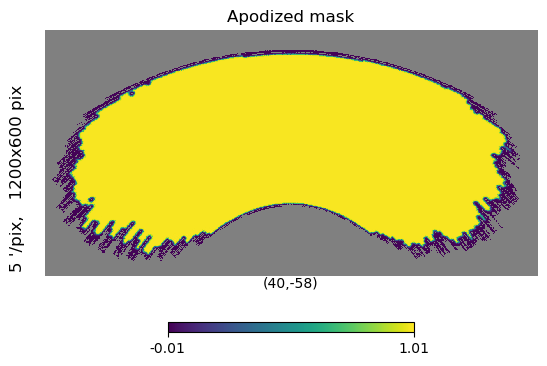

In [33]:
hp.gnomview(mask2_sm,rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -1e-2, max = 1.01,  title = r'Apodized mask')
plt.savefig('figures/apodized_mask.svg')

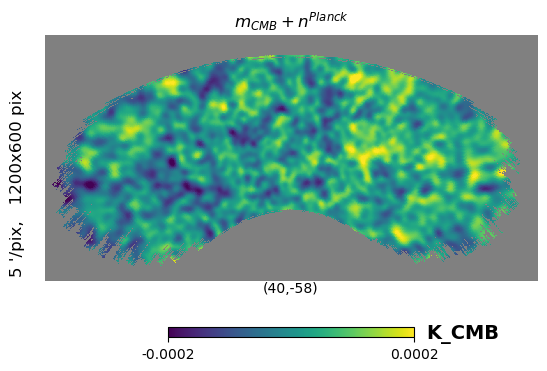

In [34]:
hp.gnomview(masked_cmbnoise_in[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -2e-4, max = 2e-4,  title = r'$m_{CMB}+n^{Planck}$', unit='K_CMB')

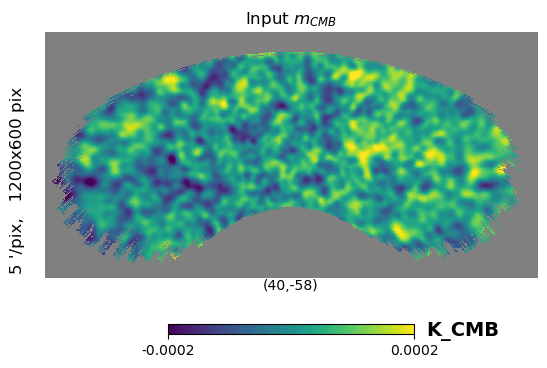

In [35]:
hp.gnomview(masked_cmb_in[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -2e-4, max = 2e-4,  title = r'Input $m_{CMB}$', unit='K_CMB')
plt.savefig('figures/input_cmb_masked.svg')

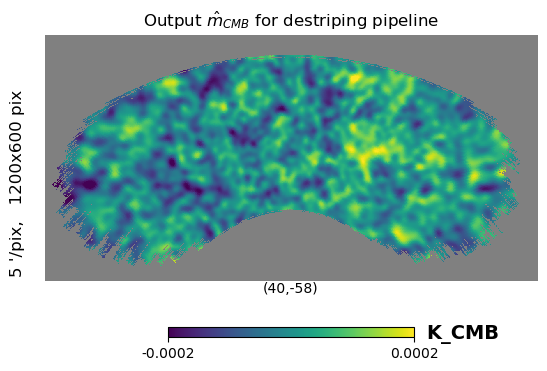

In [36]:
hp.gnomview(masked_cmbnoisedestriping[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -2e-4,max = 2e-4, title = r'Output $\hat{m}_{CMB}$ for destriping pipeline', unit='K_CMB')

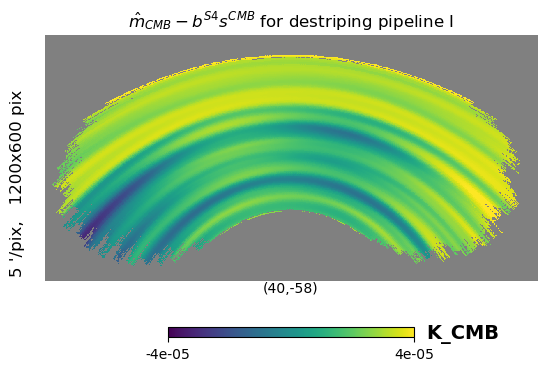

In [79]:
hp.gnomview(diff_cmb_des[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -4e-5,max = 4e-5
                , title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$ for destriping pipeline '+IQU_list[0], unit='K_CMB')
plt.savefig('figures/residual_desI.svg')

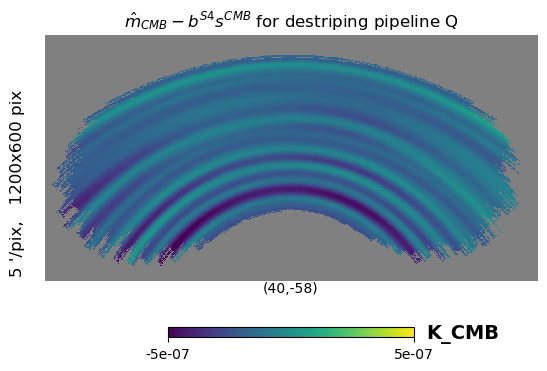

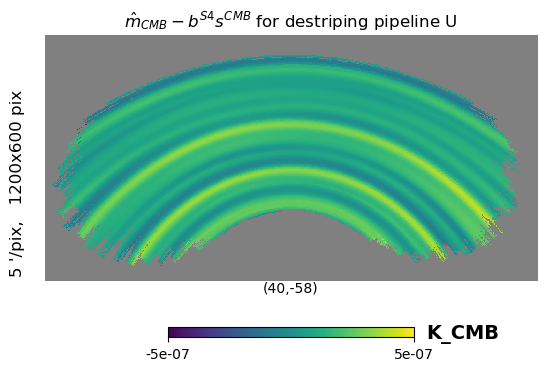

In [78]:
for i in range(1,3):
    hp.gnomview(diff_cmb_des[i],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-7,max = 5e-7           
                , title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$ for destriping pipeline '+IQU_list[i], unit='K_CMB')
    plt.savefig('figures/residual_des'+IQU_list[i]+'.svg')

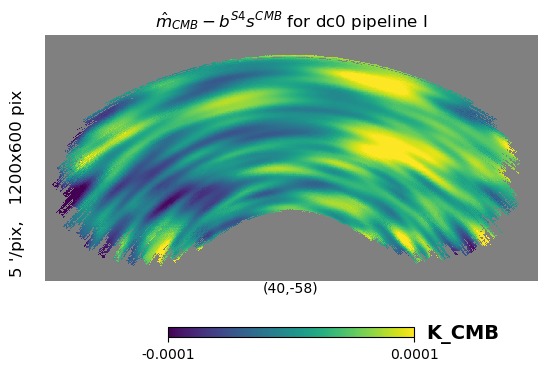

In [70]:
hp.gnomview(diff_cmb_dc0[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -1e-4,max = 1e-4            
            , title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$ for dc0 pipeline '+IQU_list[0], unit='K_CMB')
plt.savefig('figures/residual_dc0'+IQU_list[0]+'.svg')

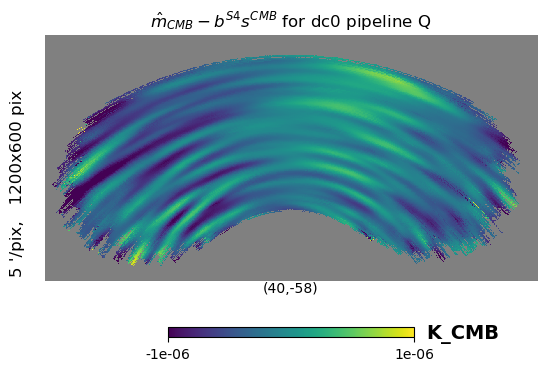

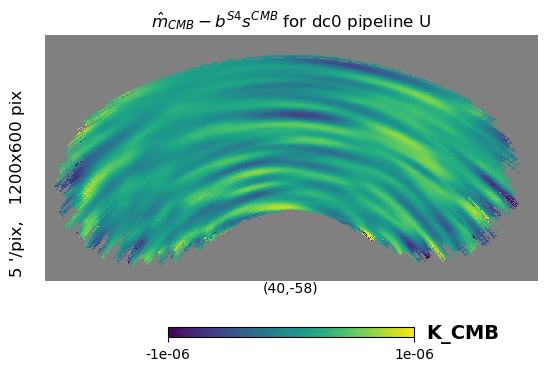

In [71]:
for i in range(1,3):
    hp.gnomview(diff_cmb_dc0[i],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -1e-6,max = 1e-6            
                , title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$ for dc0 pipeline '+IQU_list[i], unit='K_CMB')
    plt.savefig('figures/residual_dc0'+IQU_list[i]+'.svg')

In [41]:
diff_desdc0 = masked_cmbnoisedestriping-masked_cmbnoisedc0
masked_diff_desdc0 = masked_map(diff_desdc0,mask_sm)

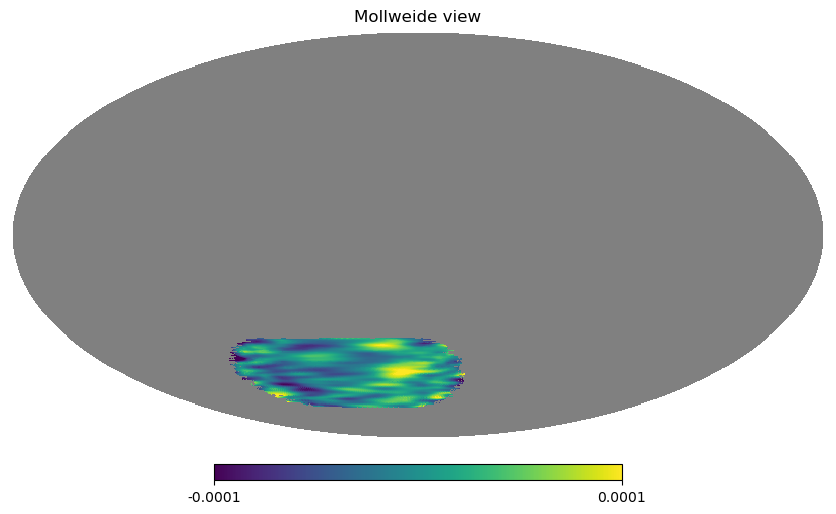

In [42]:
hp.mollview(masked_diff_desdc0[0],min = -1e-4,max = 1e-4)

1. Compute residual maps $\delta m = T(m_{in})-m_{in}$ with $m_{in} = bs+n$ for both pipelines (dc0 and destriping)

In [43]:
delta_destriping = masked_cmbnoisedestriping-masked_cmbnoise_in
delta_dc0 = masked_cmbnoisedc0-masked_cmbnoise_in

2. Add residuals to extracted maps with detector noise in the timestream, should get : $m_{cor} = bs + n^{S4}+ T(n^{Planck})$

In [44]:
masked_s4_dc0_cor = masked_s4_dc0 -diff_cmb_dc0
masked_s4_destriping_cor = masked_s4_destriping - diff_cmb_des

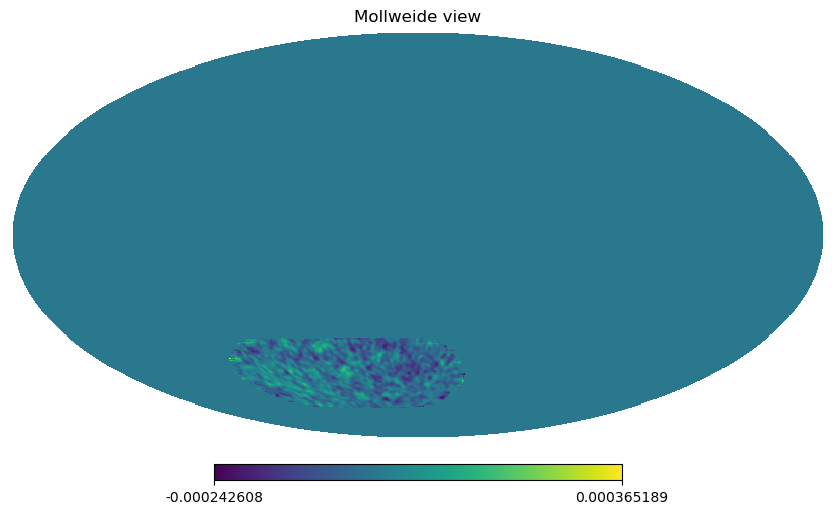

In [45]:
hp.mollview(masked_s4_dc0_cor[0])

In [46]:
diff = (masked_cmbnoisedestriping-masked_cmb_in)
diff_mask = masked_map(diff,mask_sm)

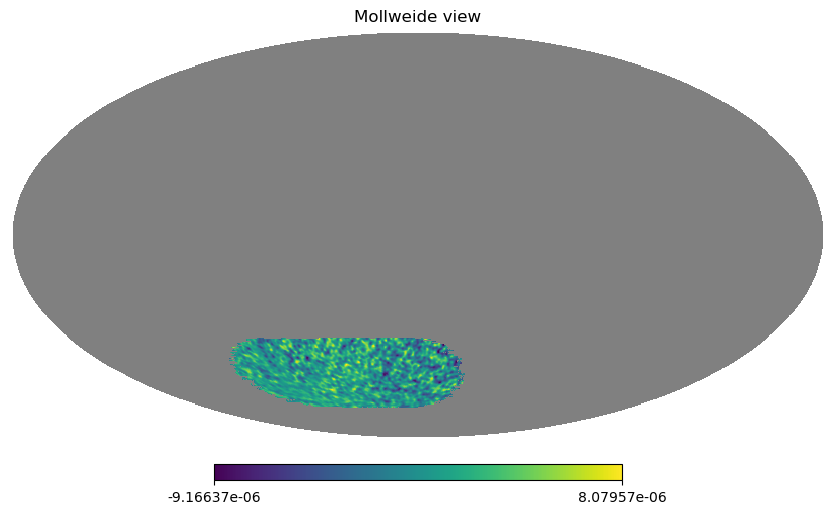

In [47]:
hp.mollview(diff_mask[1])

In [48]:
Dl_s4_destriping = D_ell(masked_s4_destriping,lmax = lmax)
Dl_s4_dc0 = D_ell(masked_s4_dc0,lmax = lmax)

In [49]:
Dl_in = D_ell(cmb_input,lmax = lmax)


In [50]:
Dl_in_noise = D_ell(cmbnoise_input,lmax = lmax)
Dl_in_noise_mask = D_ell(masked_cmbnoise_in,lmax= lmax)

In [51]:
Dl_in_mask = D_ell(masked_cmb_in,lmax= lmax)

In [52]:
Dl_s4_destriping_cor = D_ell(masked_s4_destriping_cor,lmax = lmax)
Dl_s4_dc0_cor = D_ell(masked_s4_dc0_cor,lmax = lmax)


In [53]:
hit_mask_noise = np.array(np.where(mask_sm<=0))[0]
sky_fraction= 1-(len(hit_mask_noise) / len(mask_sm))
print(f"The map covers {sky_fraction:.1%} of the sky")

The map covers 5.2% of the sky


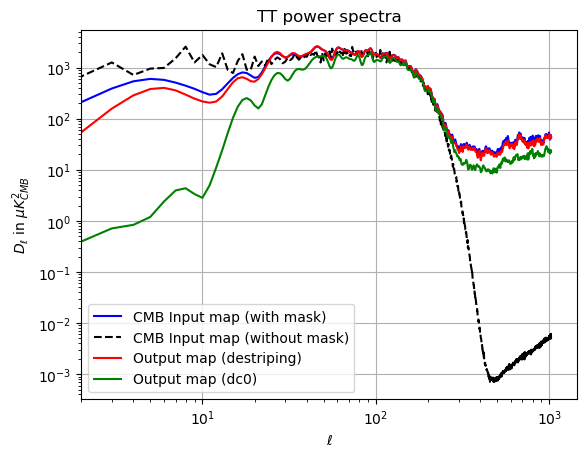

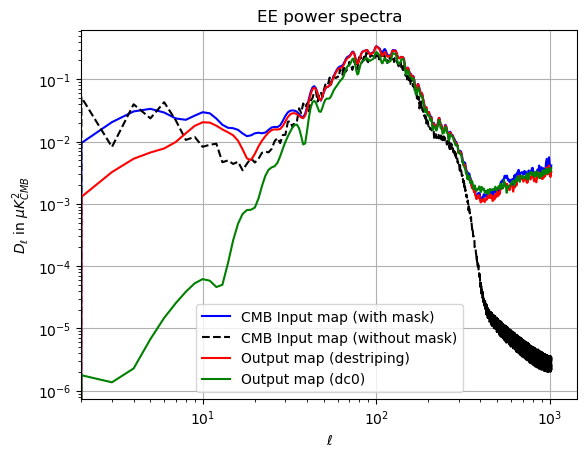

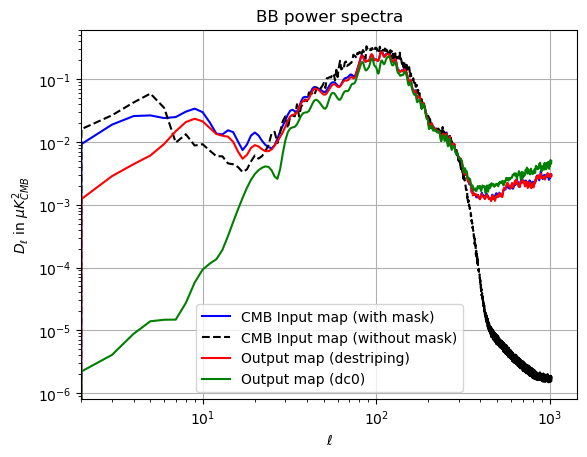

In [54]:
for i in range(3):
    plt.plot(l_arr,Dl_in_mask[i]*1e12/sky_fraction, 'b-', label = r'CMB Input map (with mask)')
    plt.plot(l_arr,Dl_in[i]*1e12, 'k--', label = r'CMB Input map (without mask)')
    #plt.plot(l_arr,Dl_in_noise_mask[0]*1e12/sky_fraction, 'g-', label = r'CMB+noise Input map (with mask)')
    #plt.plot(l_arr,Dl_in_noise[0]*1e12, 'r-', label = r'CMB+noise Input map (without mask)')
    plt.plot(l_arr,Dl_s4_destriping[i]*1e12/sky_fraction, 'r-', label = r'Output map (destriping)')
    #plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
    #plt.plot(l_arr,Dl_s4_destriping_cor[2]/Dl_in_mask[2], 'k--', label = r'Ratio with mode addition from Planck')

    #plt.plot(l_arr,Dl_s4_destriping_cor[2]*1e12/sky_fraction, 'k--', label = r'Output corrected map (destriping)')

    plt.plot(l_arr,Dl_s4_dc0[i]*1e12/sky_fraction, 'g-', label = r'Output map (dc0)')
    #plt.plot(l_arr,Dl_s4_dc0_cor[2]*1e12/sky_fraction, 'r-', label = r'Output corrected map (dc0)')

    #plt.plot(l_arr,Dl_diff_noise[0]*1e12/sky_fraction, 'r.', label = r'Residual map')
    plt.xlabel('$\ell$')
    plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
    plt.legend(loc = 'best')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(2*mode_list[i]+' power spectra')
    plt.xlim(left = 2)
    plt.grid()
    plt.savefig('figures/cls_comparison'+2*mode_list[i]+'.svg')
    plt.show()

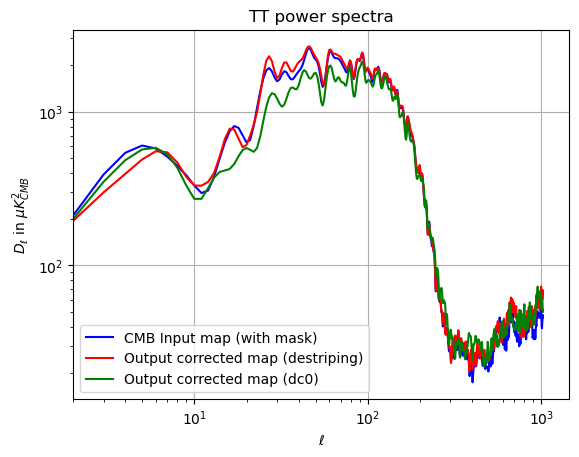

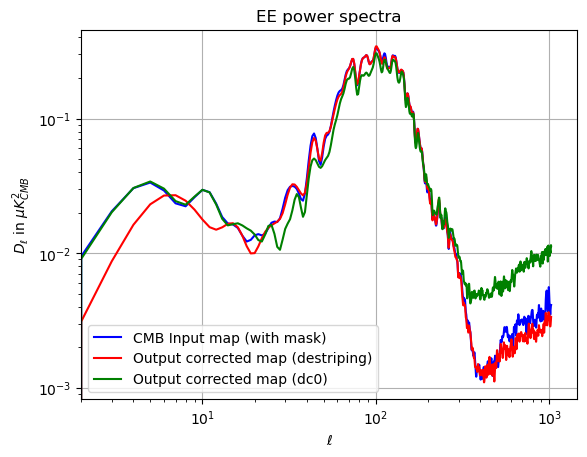

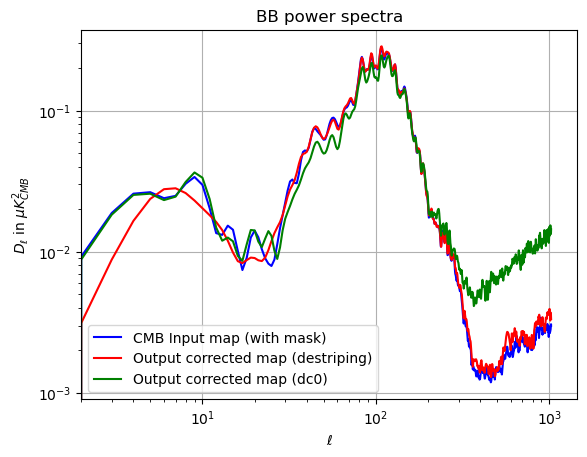

In [65]:
for i in range(3):
    plt.plot(l_arr,Dl_in_mask[i]*1e12/sky_fraction, 'b-', label = r'CMB Input map (with mask)')
    #plt.plot(l_arr,Dl_in[i]*1e12, 'k--', label = r'CMB Input map (without mask)')
    #plt.plot(l_arr,Dl_in_noise_mask[0]*1e12/sky_fraction, 'g-', label = r'CMB+noise Input map (with mask)')
    #plt.plot(l_arr,Dl_in_noise[0]*1e12, 'r-', label = r'CMB+noise Input map (without mask)')
    #plt.plot(l_arr,Dl_s4_destriping[i]*1e12/sky_fraction, 'r-', label = r'Output map (destriping)')
    #plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
    #plt.plot(l_arr,Dl_s4_destriping_cor[2]/Dl_in_mask[2], 'k--', label = r'Ratio with mode addition from Planck')

    plt.plot(l_arr,Dl_s4_destriping_cor[i]*1e12/sky_fraction, 'r-', label = r'Output corrected map (destriping)')

    #plt.plot(l_arr,Dl_s4_dc0[i]*1e12/sky_fraction, 'g-', label = r'Output map (dc0)')
    plt.plot(l_arr,Dl_s4_dc0_cor[i]*1e12/sky_fraction, 'g-', label = r'Output corrected map (dc0)')

    #plt.plot(l_arr,Dl_diff_noise[0]*1e12/sky_fraction, 'r.', label = r'Residual map')
    plt.xlabel('$\ell$')
    plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
    plt.legend(loc = 'best')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(2*mode_list[i]+' power spectra')
    plt.xlim(left = 2)
    plt.grid()
    #plt.savefig('figures/cls_comparison_correction'+2*mode_list[i]+'.svg')
    plt.show()

/tmp/ipykernel_1435963/4089808504.py:10: RuntimeWarning: invalid value encountered in divide
  plt.plot(l_arr,Dl_s4_destriping_cor[i]/Dl_in_mask[i], 'r-', label = r'Output corrected map (destriping)')
/tmp/ipykernel_1435963/4089808504.py:13: RuntimeWarning: invalid value encountered in divide
  plt.plot(l_arr,Dl_s4_dc0_cor[i]/Dl_in_mask[i], 'g-', label = r'Output corrected map (dc0)')


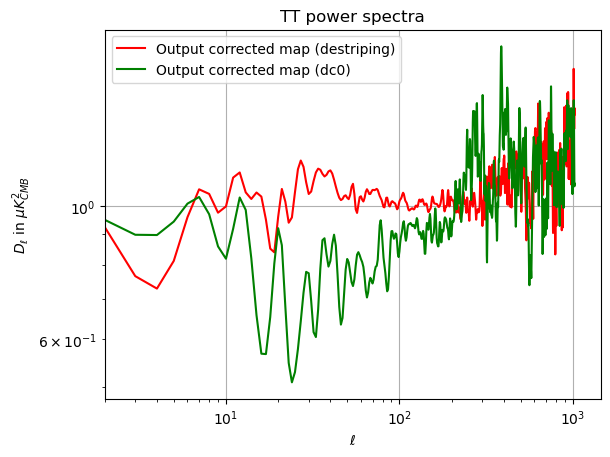

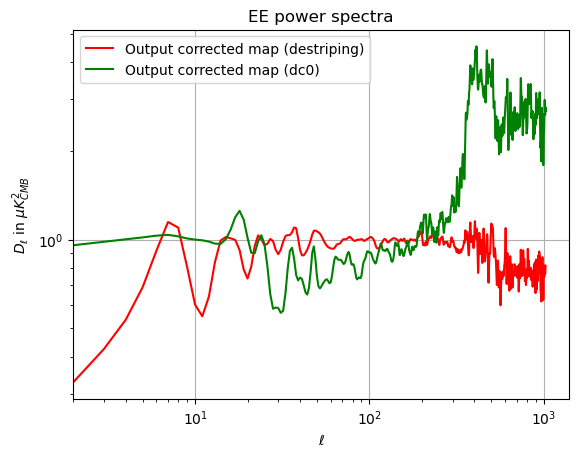

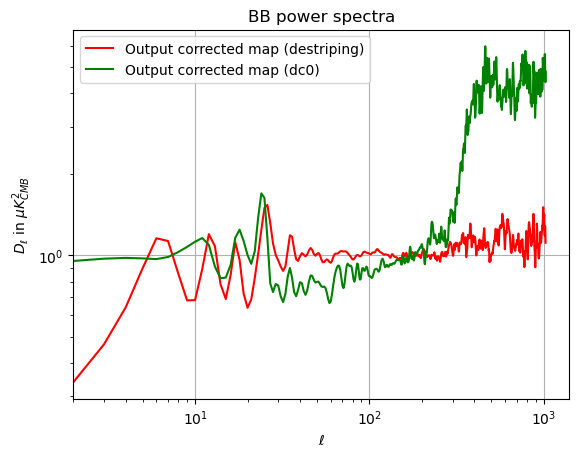

In [80]:
for i in range(3):
    #plt.plot(l_arr,1e12/sky_fraction, 'b-', label = r'CMB Input map (with mask)')
    #plt.plot(l_arr,Dl_in[i]*1e12, 'k--', label = r'CMB Input map (without mask)')
    #plt.plot(l_arr,Dl_in_noise_mask[0]*1e12/sky_fraction, 'g-', label = r'CMB+noise Input map (with mask)')
    #plt.plot(l_arr,Dl_in_noise[0]*1e12, 'r-', label = r'CMB+noise Input map (without mask)')
    #plt.plot(l_arr,Dl_s4_destriping[i]*1e12/sky_fraction, 'r-', label = r'Output map (destriping)')
    #plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
    #plt.plot(l_arr,Dl_s4_destriping_cor[2]/Dl_in_mask[2], 'k--', label = r'Ratio with mode addition from Planck')

    plt.plot(l_arr,Dl_s4_destriping_cor[i]/Dl_in_mask[i], 'r-', label = r'Output corrected map (destriping)')

    #plt.plot(l_arr,Dl_s4_dc0[i]*1e12/sky_fraction, 'g-', label = r'Output map (dc0)')
    plt.plot(l_arr,Dl_s4_dc0_cor[i]/Dl_in_mask[i], 'g-', label = r'Output corrected map (dc0)')

    #plt.plot(l_arr,Dl_diff_noise[0]*1e12/sky_fraction, 'r.', label = r'Residual map')
    plt.xlabel('$\ell$')
    plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
    plt.legend(loc = 'best')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(2*mode_list[i]+' power spectra')
    plt.xlim(left = 2)
    plt.grid()
    #plt.savefig('figures/cls_comparison_correction'+2*mode_list[i]+'.svg')
    plt.show()

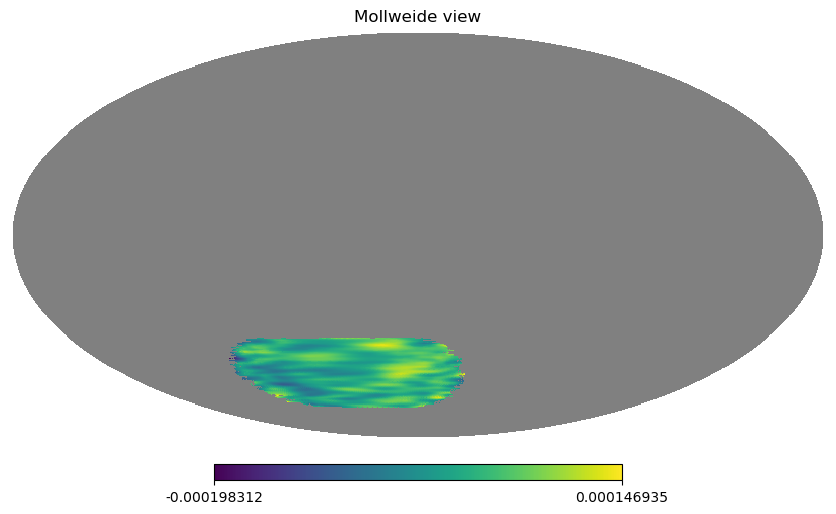

In [100]:
hp.mollview(diff_cmb_dc0[0])

$\sigma (s-Ts)$

In [96]:
sigdc0 = np.std(diff_cmb_dc0)
sigdes = np.std(diff_cmb_des)


In [98]:
sigdc0

3.6823750456132066e+29

In [97]:
print('$\sigma^{dc0} = $'+str(sigdc0))
print('$\sigma^{des} = $'+str(sigdes))

$\sigma^{dc0} = $3.6823750456132066e+29
$\sigma^{des} = $3.6823750456132066e+29


In [56]:

Dl_cmb_des_mask = D_ell(mask_cmb_des,lmax=lmax)

/tmp/ipykernel_1435963/4130570690.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
/tmp/ipykernel_1435963/4130570690.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(l_arr,Dl_cmb_des_mask[2]/Dl_in_mask[2], 'g-', label = r'Ratio for CMB only destriping')


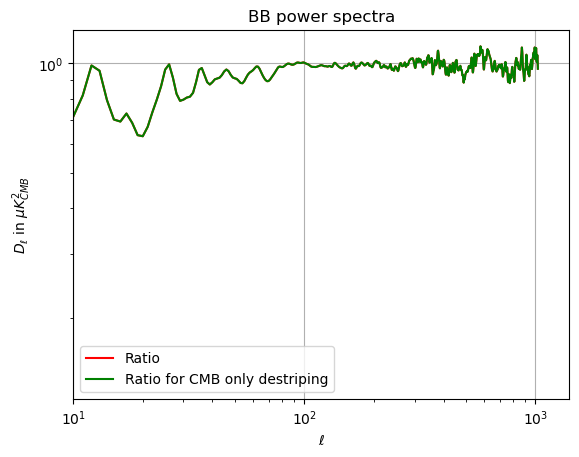

In [57]:
plt.plot(l_arr,Dl_s4_destriping[2]/Dl_in_mask[2], 'r-', label = r'Ratio')
#plt.plot(l_arr,Dl_s4_destriping_cor[2]/Dl_in_mask[2], 'k--', label = r'Ratio with mode addition from Planck')
plt.plot(l_arr,Dl_cmb_des_mask[2]/Dl_in_mask[2], 'g-', label = r'Ratio for CMB only destriping')

#plt.plot(l_arr,Dl_s4_destriping_cor[0]*1e12/sky_fraction, 'r-', label = r'Output corrected map (destriping)')

#plt.plot(l_arr,Dl_s4_dc0[0]*1e12/sky_fraction, 'g-', label = r'Output map (dc0)')
#plt.plot(l_arr,Dl_s4_dc0_cor[0]*1e12/sky_fraction, 'r-', label = r'Output corrected map (dc0)')

#plt.plot(l_arr,Dl_diff_noise[0]*1e12/sky_fraction, 'r.', label = r'Residual map')
plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
plt.legend(loc = 'best')
plt.xscale('log')
plt.yscale('log')
plt.title(2*mode_list[2]+' power spectra')
plt.xlim(left = 10)
plt.grid()
##plt.savefig(output_noise+'/cls_comparison'+2*mode_list[0]+'.svg')
plt.show()

In [58]:
diff0 = mask_cmb_des-masked_cmb_in
diff_mask2  = masked_map(diff0,mask_sm)

In [59]:
diff3 = cmb_dc0 - cmb_input
diff_mask3 = masked_map(diff3,mask_sm)

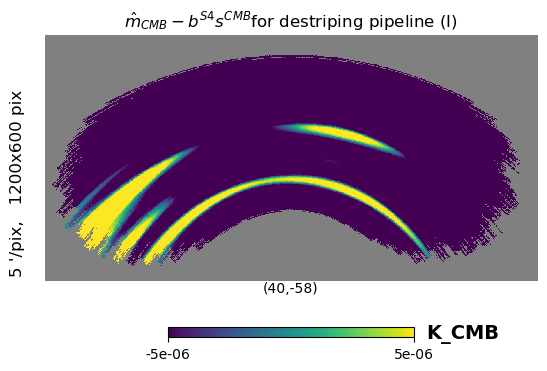

In [60]:
hp.gnomview(diff_mask2[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-6,max = 5e-6, title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$' +'for destriping pipeline (I)', unit='K_CMB')

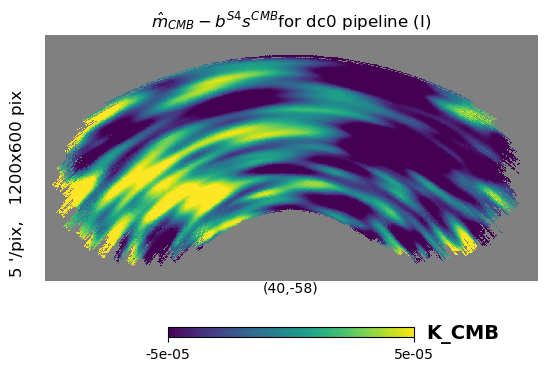

In [61]:
hp.gnomview(diff_mask3[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-5,max = 5e-5, title = r'$\hat{m}_{CMB}-b^{S4}s^{CMB}$' +'for dc0 pipeline (I)', unit='K_CMB')

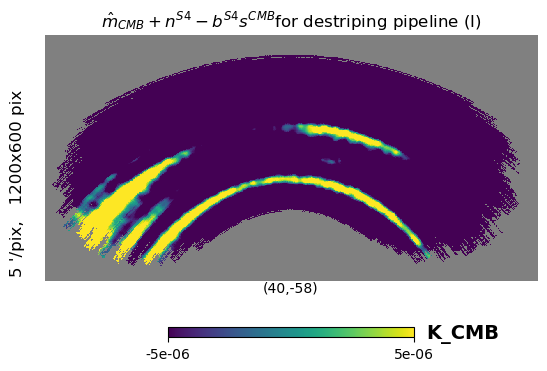

In [62]:
hp.gnomview(diff_mask[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, min = -5e-6,max = 5e-6, title = r'$\hat{m}_{CMB}+n^{S4}-b^{S4}s^{CMB}$' +'for destriping pipeline (I)', unit='K_CMB')